In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..', '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga



Populating the interactive namespace from numpy and matplotlib


### Process indrops counts and build loompy objects

In [2]:
import stage6_timecourse
data_objs = {}

# This is the object for the inDrops processed data. In the same format as for the Stages 3-6 data. 
s6 = 'stage6_tc'
data_objs[s6] = stage6_timecourse.Stage6_timecourse('../data/indrops_intermediate')


In [3]:
%rm ../data/quality_filter/*.loom

counts = data_objs[s6].counts.values.T
cell_name = data_objs[s6].counts.index
cell_week = np.array([int(c[8]) for c in cell_name])
cell_flask = np.array([int(c[4]) for c in cell_name])
cell_batch = np.array([c.split('.')[0] for c in cell_name])
gene_name = data_objs[s6].counts.columns

min_cells_per_valid_gene = 10

loom_fn = f'../data/quality_filter/stage6.all_cells.raw.loom'
loompy.create(loom_fn, {'': counts},
                  {'Gene': gene_name,
                   '_Valid': (counts.sum(1).A.ravel() > min_cells_per_valid_gene),
                      },
                  {'CellID': cell_name,
                   '_Valid': np.ones(cell_name.shape).astype(int),
                   'CellWeek': cell_week, 
                   'CellFlask': cell_flask,
                   'CellBatch': cell_batch,
                      })

for wk in range(6):
    cell_filter = np.where(cell_week == wk)[0]
    
    loom_fn = f'../data/quality_filter/stage6.week{wk}.raw.loom'
    loompy.create(loom_fn, {'': counts[:, cell_filter]},
                      {'Gene': gene_name,
                       '_Valid': (counts[:, cell_filter].sum(1).A.ravel() > min_cells_per_valid_gene),
                          },
                      {'CellID': cell_name[cell_filter],
                       '_Valid': np.ones(cell_name[cell_filter].shape).astype(int),
                       'CellWeek': cell_week[cell_filter], 
                       'CellFlask': cell_flask[cell_filter], 
                       'CellBatch': cell_batch[cell_filter], 
                          })


In [4]:
## load loompy objects

In [11]:
loom_fn = f'../data/quality_filter/stage6.all_cells.raw.loom'
ds = loompy.connect(loom_fn)
ds.vals = sp.sparse.csr_matrix(ds.layers[""][:, :])


In [12]:
tds = OrderedDict()
for tp in range(6):
    loom_fn = f'../data/quality_filter/stage6.week{tp}.raw.loom'
    tds[tp] = loompy.connect(loom_fn)
    tds[tp].vals = sp.sparse.csr_matrix(tds[tp].layers[""][:, :])
    

## 1. Quality filtering

### Automated filtering

In [13]:
seed = 2949680
for tp in tds.keys():
    cga.highvar_pca(tds[tp], tds[tp].vals, namespace='Raw', seed=seed)
    
    np.random.seed(seed)
    tds[tp].ca["RawHighVarTSNE"] = cg.TSNE(perplexity=100).layout(tds[tp].ca[r"RawHighVarPCA"])
    
    cga.low_qual_cluster_detector(tds[tp], tds[tp].vals,
        n_pcs = 20, nn_k=200, clustering_resolution = 2.0, n_markers = 50,
        seed=seed)

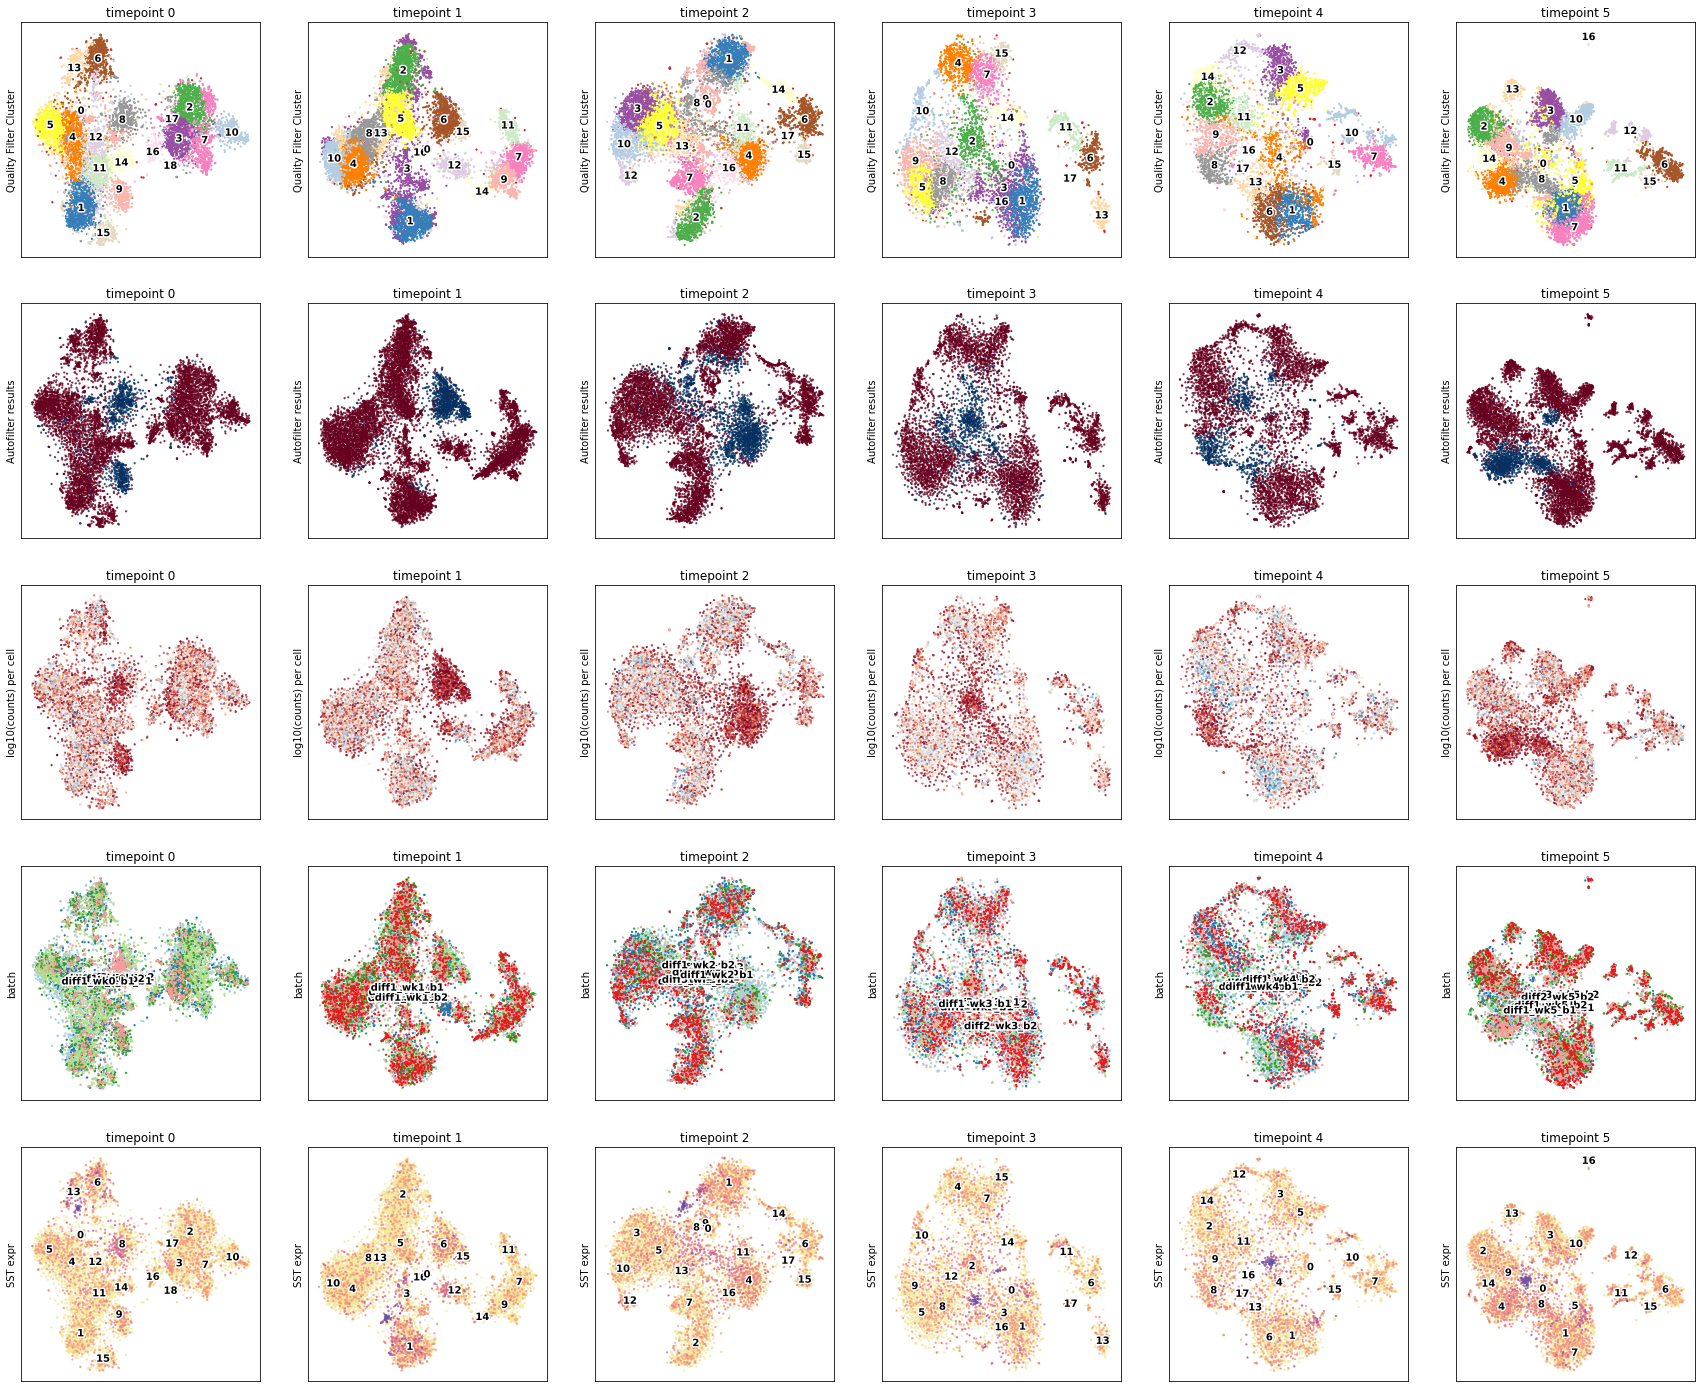

In [14]:
vis.plot_auto_qual_filter_by_time_point(ds_dict=tds, show_genes=['SST'])

### Verify the automated filter

In [15]:
# Make sure we don't exclude the small SST cluster
manual_changes = defaultdict(lambda : dict(), {
                        1: {'force_false': [12,], },
                        2: {'force_true': [8,], },
                        3: {'force_true': [12,], },
                        4: {'force_true': [11,], },
                        })

for tp in tds.keys():
    _tds = tds[tp]
    _tds.ca['__Filter2__Verified_quality'] = cgm.update_cluster_based_filter(
            _tds.ca['__Filter1__Automated_quality'],
            _tds.ca['QualFilterLabels'],
            **manual_changes[tp])
    

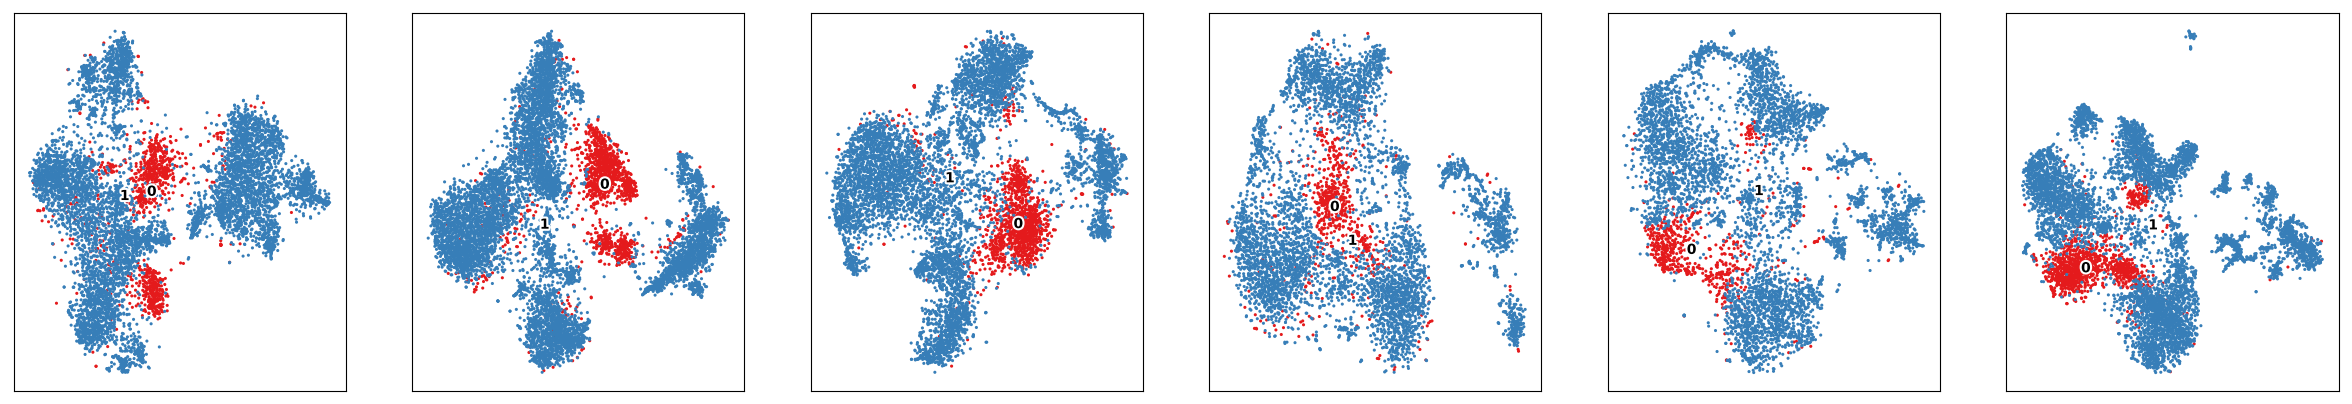

In [16]:

vis.plot_attr_by_time_point(tds, '__Filter2__Verified_quality')

In [17]:
cgm.merge_split_dataset_filter(tds, ds, '__Filter1__Automated_quality')
cgm.merge_split_dataset_filter(tds, ds, '__Filter2__Verified_quality')

In [18]:
# train_filter = ds.ca['__Filter2__Verified_quality'] > 0
# train_cells = np.where(train_filter)[0]
# seed = 86787293
# cga.highvar_pca(ds, ds.vals, namespace='Raw', seed=seed, train_cells=train_cells)

In [19]:
cluster_labels = cga.mknn_leiden_labels(ds.ca['RawHighVarPCA'][:, :25][train_cells], train_filter,
                                        nn_k=250, clustering_resolution=3.0, seed=seed)

ds.ca['__Labels1__GlobalQualFilteringClusters'] = cluster_labels.original

### Quality filter, using clusters called on entire dataset

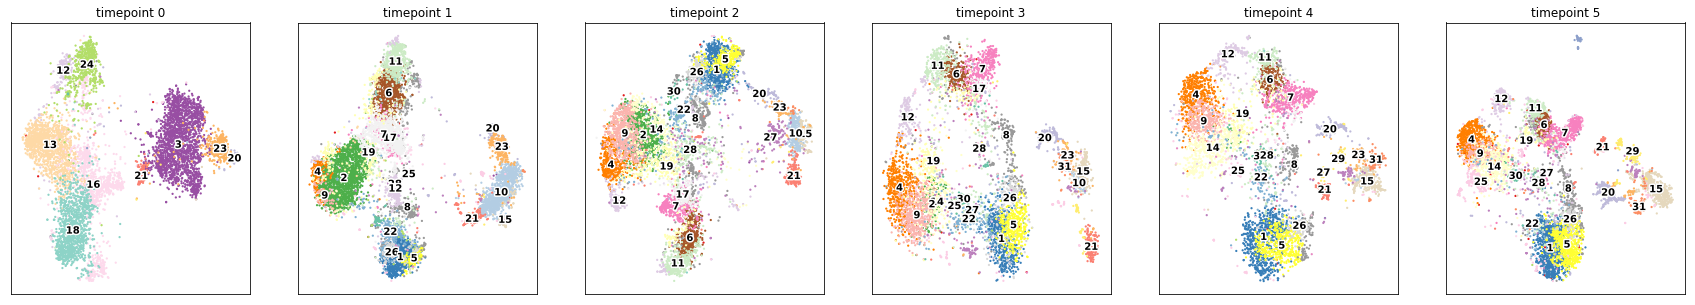

In [22]:
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels1__GlobalQualFilteringClusters'][train_cells],
                                            index=ds.ca.CellID[train_cells]), 
                          int_categories=True)

In [23]:
# Cluster 6 contains doublets from PH to SCb and EC. 
# Cluster 20 contains doublets/odd cells from SCb to EC. 
# Both of these clusters contain many of the cells suggested for removal by the automated filter above. 
# Unfortunately, cluster 6 also contains all the SST/HHEX+ cells which we want to preserve. 
# Let's refine cluster 6's labels, keep the SST/HHEX+ cells and proceed. 

_labels_to_refine = (6,)
_refined_labels = cga.recluster_label(ds.ca['FinalHighVarPCA'], cluster_labels.original, _labels_to_refine,
                              nn_k=200, min_cluster_size=10, seed=8903811, clustering_resolution=0.5)

ds.ca['__Labels1__GlobalQualFilteringClusters'] = _refined_labels.original

In [25]:
Counter(_refined_labels.original[cluster_labels.original==6])
# Exclude all of these BUT 30 (which is the SST+ cells)


Counter({22: 929, 28: 521, 30: 312, 33: 37})

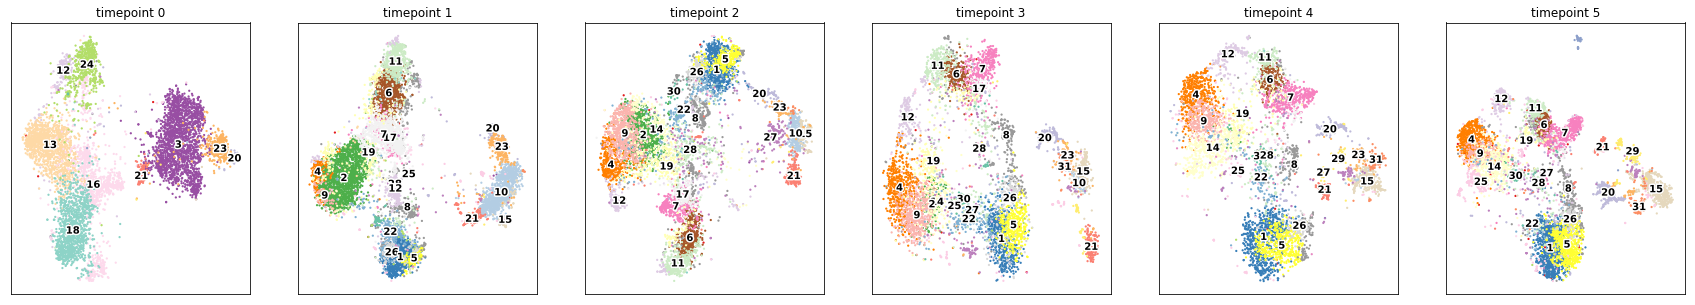

In [26]:
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels1__GlobalQualFilteringClusters'][train_cells],
                                            index=ds.ca.CellID[train_cells]), 
                          int_categories=True)

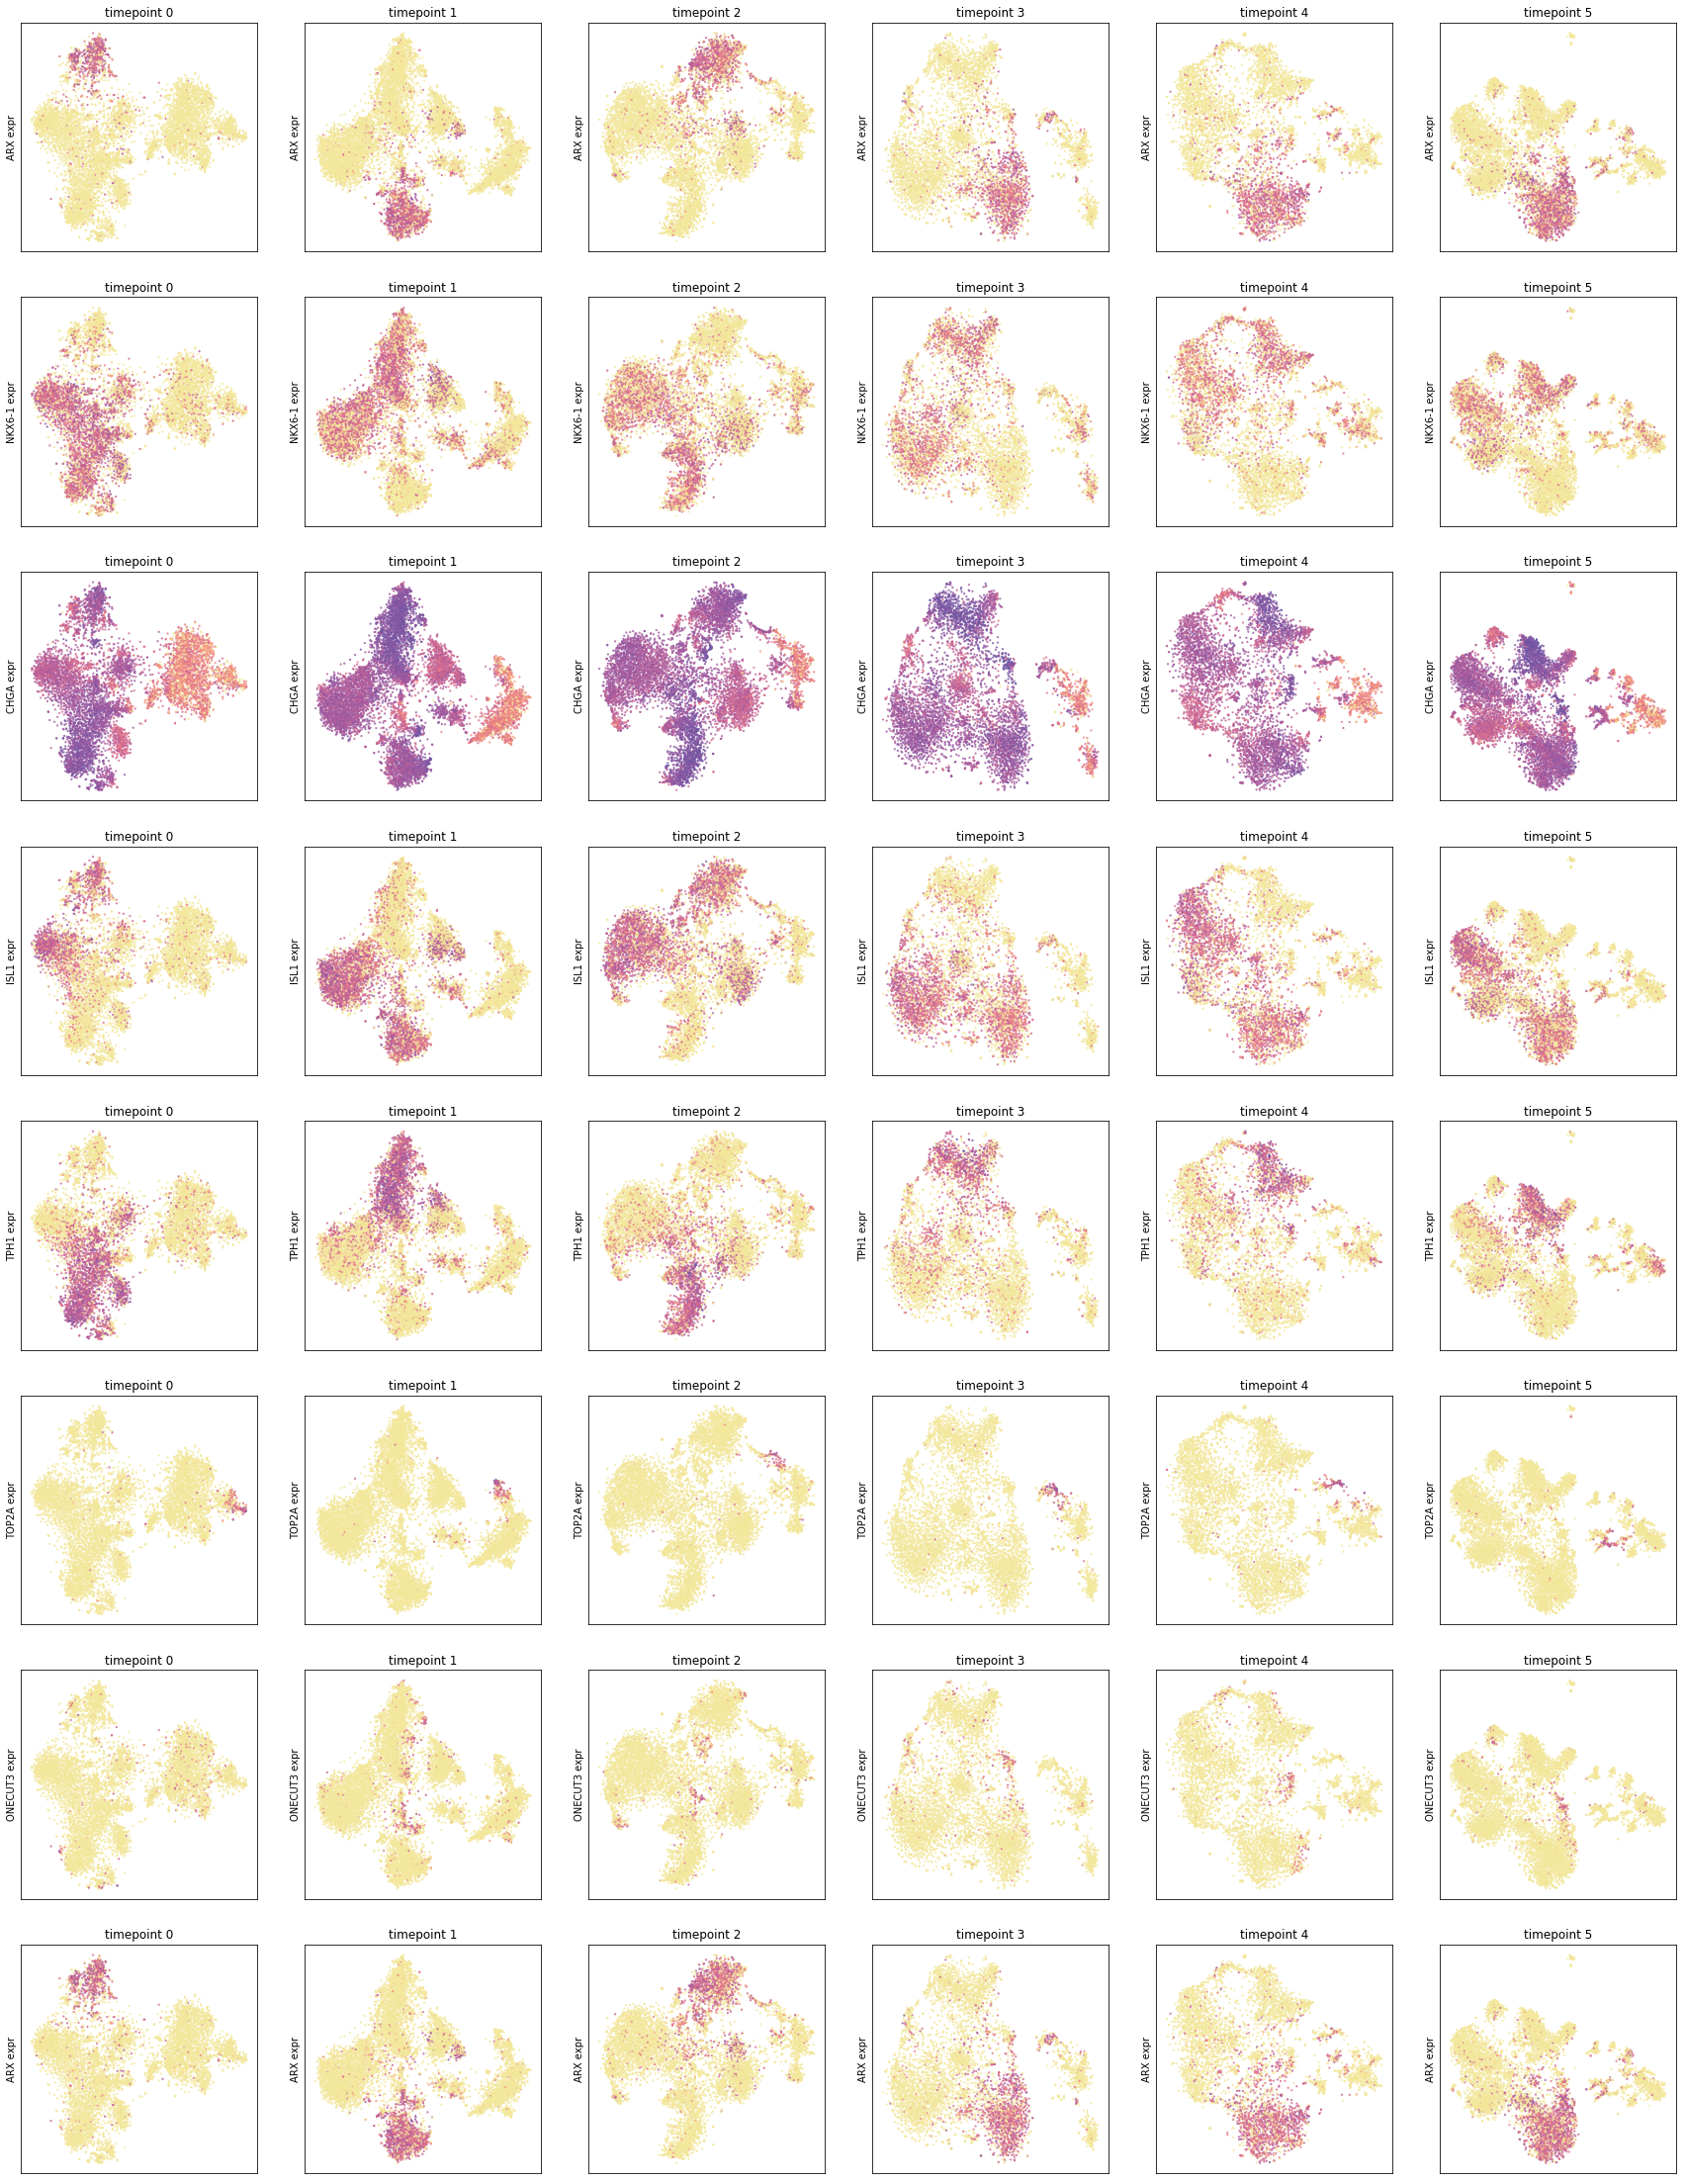

In [28]:
vis.plot_gene_by_time_point(tds, ['ARX', 'NKX6-1', 'CHGA', 'ISL1', 'TPH1', 'TOP2A', 'ONECUT3', 'ARX'])


In [29]:
# The clusters flagged below are doublet like, or otherwise low-quality.
# They cause artefactual clustering if not removed
ds.ca['__Filter3__Global_quality'] = cgm.update_cluster_based_filter(
            ds.ca['__Filter2__Verified_quality'],
            ds.ca['__Labels1__GlobalQualFilteringClusters'],
            force_false = (19, 22, 27, 28, 33))

vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Filter3__Global_quality'],
                                            index=ds.ca.CellID), 
                          int_categories=True)


In [31]:
seed = 7653313
final_train_filter = ds.ca['__Filter3__Global_quality'] > 0
final_train_cells = np.where(final_train_filter)[0]
cga.highvar_pca(ds, ds.vals, namespace='Final', seed=seed, train_cells=final_train_cells)


In [32]:
global_cluster_labels = cga.mknn_leiden_labels(ds.ca['FinalHighVarPCA'][final_train_cells], final_train_filter,
                                        nn_k=250, clustering_resolution=3.0, seed=seed)
ds.ca['__Labels2__Clusters'] = global_cluster_labels.original

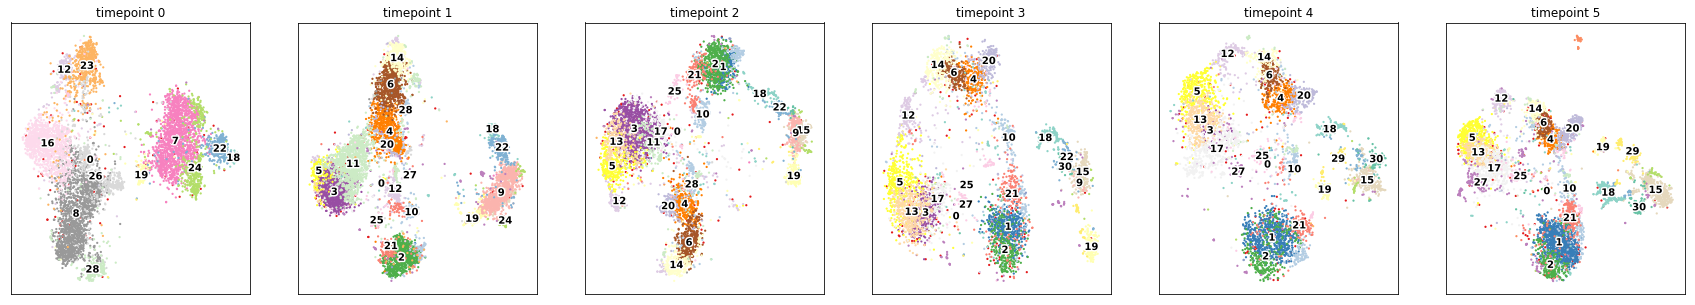

In [33]:
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels2__Clusters'][final_train_cells],
                                            index=ds.ca.CellID[final_train_cells]), 
                          int_categories=True)


In [34]:
# We need to refine the labels corresponding to SC-EC, SC-beta and neurog3+ cells. 
# We do this by taking only those cells and doing another round of clustering.

_labels_to_refine = (8, 16, 26)
_cluster_labels = ds.ca['__Labels2__Clusters']
refined = cga.recluster_label(ds.ca['FinalHighVarPCA'], _cluster_labels, _labels_to_refine,
                              nn_k=200, min_cluster_size=10, seed=1988441, clustering_resolution=0.5)
ds.ca['__Labels3__RefinedClusters'] = refined.original
    


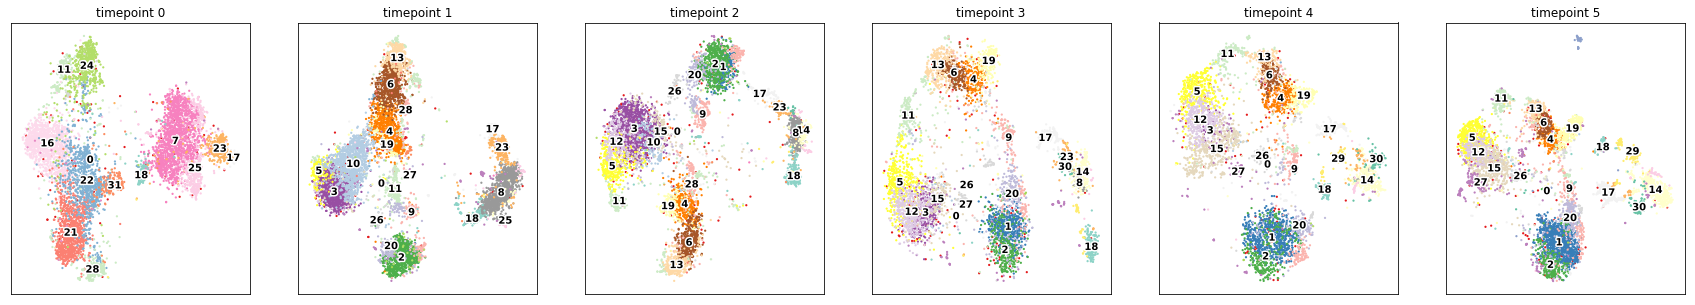

In [35]:
# These are the final clusters.
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels3__RefinedClusters'][final_train_cells],
                                            index=ds.ca.CellID[final_train_cells]), 
                          int_categories=True)


### Cluster interpretation

In [36]:
# Get pseudobulk values for the clusters and use these to assign labels using a set of predefined markers

pb_labels = cgm.CellLabels(ds.ca['__Labels3__RefinedClusters'])
cluster_pseudobulk = cga.pseudobulk_from_label(ds, pb_labels)
cluster_pseudobulk_z = ((cluster_pseudobulk - cluster_pseudobulk.mean())/cluster_pseudobulk.std()).fillna(0.0)
    

In [39]:
# Load autolabeling genes
autolabel_enrichment = utils.load_df(f'../data/clustering/stage6.autolabels.df.npz')

autolabel_corr = pd.DataFrame(utils.two_array_corr((autolabel_enrichment > 0).astype(float).values,
                                                   cluster_pseudobulk_z.T.loc[autolabel_enrichment.index].values),
                                 columns = autolabel_enrichment.columns,
                                 index=cluster_pseudobulk_z.T.columns)

In [40]:
autolabel_calls = autolabel_corr.idxmax(1)
autolabel_calls = autolabel_calls.to_dict()
autolabel_calls[0] = ''

# print(pd.Series(autolabel_calls))
ann_labels = cgm.CellLabels(np.array([autolabel_calls[li] for li in pb_labels.original]), null_label='')
ds.ca['__Labels4__AnnotatedLabels'] = ann_labels.original


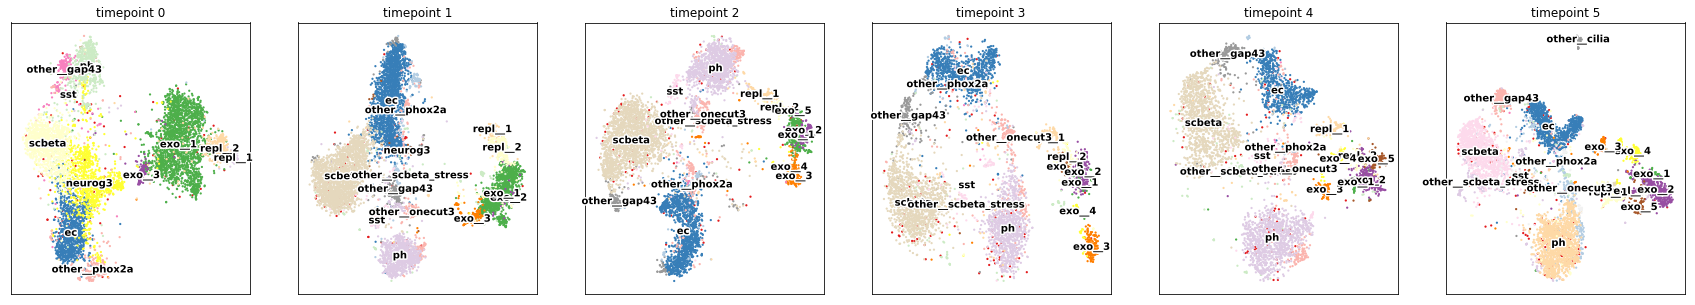

In [41]:

vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels4__AnnotatedLabels'][final_train_cells],
                                            index=ds.ca.CellID[final_train_cells]), 
                          int_categories=False, min_elements_for_label=10)


### Classifier training and prediction to recover cells that were removed by the quality filter

In [42]:
# Use these labels in classifier training and update the labels.
classifier_labels = cga.update_labels_with_classifier(ds, ann_labels, seed=9182011,
#                                                       do_not_classify_filter= do_not_classify,
                                                      recovery_classification_threshold=0.66)

ds.ca['__Labels5__ClassifierLabels_detailed'] = classifier_labels.original

In [43]:
ds.ca['__Labels6__ClassifierLabels'] = np.array([s.split('__')[0] for s in ds.ca['__Labels5__ClassifierLabels_detailed']])

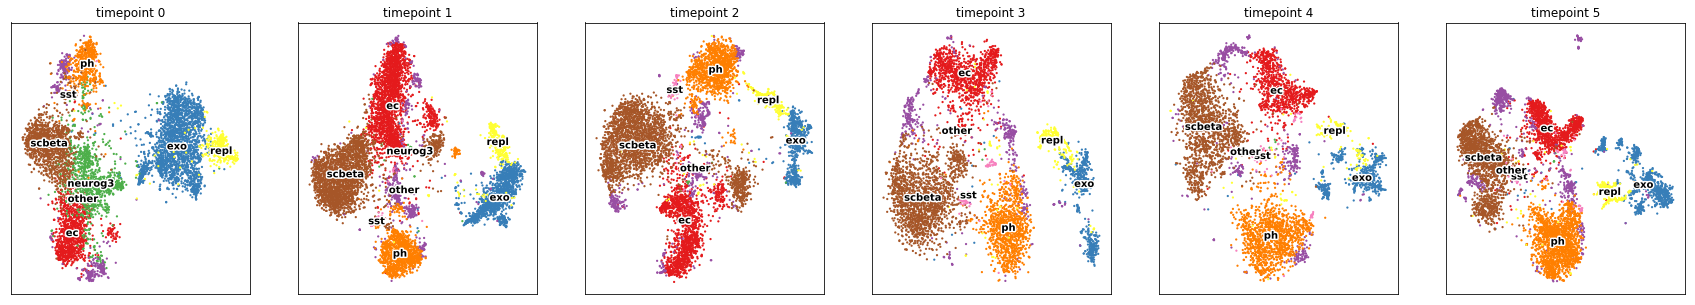

In [47]:
classifier_labels = cgm.CellLabels(ds.ca['__Labels6__ClassifierLabels'], null_label='')
vis.plot_cat_by_time_point(tds, pd.Series(classifier_labels.original[classifier_labels.is_labelled],
                                            index=ds.ca.CellID[classifier_labels.is_labelled]), 
                          int_categories=False, min_elements_for_label=10)


### Copy to a file containing only the unfiltered data

In [48]:
attributes_to_copy = [
    ('CellID', 'CellID'),
    ('CellBatch', 'CellBatch'),
    ('CellWeek', 'CellWeek'),
    ('CellFlask', 'CellFlask'),
    ('_Valid', '_Valid'),
    ('__Labels6__ClassifierLabels', 'Labels'),
    ('__Labels5__ClassifierLabels_detailed', 'DetailedLabels'),
    ('__Filter3__Global_quality', '_TrainFilter'),
    ]

%rm ../data/complete_processing/stage6.processed.loom
%mkdir ../data/complete_processing/
min_cells_per_valid_gene = 10

new_loom_fn = f'../data/complete_processing/stage6.processed.loom'

f_cells = np.where(ds.ca.__Labels6__ClassifierLabels != '')[0]
loompy.create(new_loom_fn, {'': ds.vals[:, f_cells]},
              {'Gene': ds.ra.Gene,
               '_Valid': (ds.vals[:, f_cells].sum(1).A.ravel() > min_cells_per_valid_gene)
                  },
              {new_attr_name: ds.ca[old_attr_name][f_cells] for old_attr_name, new_attr_name in attributes_to_copy},
             )


## Output pseudobulk values for combinations of labels and time

In [49]:
pds = loompy.connect(new_loom_fn)
pds.vals = sp.sparse.csr_matrix(pds.layers[""][:, :])

In [50]:
time_labels = cgm.CellLabels(np.array([f'{tp}__{cl}' for tp,cl in zip(pds.ca.CellWeek, pds.ca.Labels)]), null_label="")
full_labels = cgm.CellLabels(pds.ca.Labels, null_label="")
detailed_labels = cgm.CellLabels(pds.ca.DetailedLabels, null_label="")

for _labels, label_name in [(time_labels, 'time_labels'),
                        (full_labels, 'labels'),
                        (detailed_labels, 'det_labels')]:
    

    tp_pb = cga.pseudobulk_from_label(pds, _labels, norm_total=10**6)
    tp_expr = cga.expressed_fraction_from_label(pds, _labels)
    
    utils.save_df(tp_pb, f'../data/complete_processing/stage6.{label_name}.pseudobulk_tpm.df.npz')
    utils.save_df(tp_expr, f'../data/complete_processing/stage6.{label_name}.expr_frac.df.npz')

In [55]:
# Train PCA with cells that were never filter, and week >0
train_cells = np.where((pds.ca.CellWeek > 0) & (pds.ca._TrainFilter > 0))[0]

normalizer = cgm.CountsNormalizer()
normalizer.fit(pds.vals)

features = cgm.FeatureSelection()
features.fit(pds, pds.vals, cells=train_cells)
n_cells = len(normalizer.totals)

_valid_genes = pds.ra._Valid

n_hv = 2000
n_pcs = 25

genes = features.select_genes(n_genes=n_hv, valid_genes=_valid_genes.astype(bool))
high_var_pca = cgm.PCAProjection(genes=genes, max_n_components=n_pcs)
high_var_pca.fit(pds.vals, normalizer=normalizer, cells=train_cells)

high_var_pca_transformed = high_var_pca.transform(pds.vals, normalizer=normalizer)

pca_proj = pd.DataFrame(high_var_pca_transformed, index=pds.ca.CellID)
utils.save_df(pca_proj, 'stage6.pca_proj.n_hvgs{n_hv}.n_pcs{n_pcs}.nowk0.df.npz')

# execute
# scripts/run_tsne.py stage6.pca_proj.n_hvgs{n_hv}.n_pcs{n_pcs}.nowk0.df.npz stage6.tsne_proj.df.npz -s 3452921 -p 200 -i 100000 -r 25 -v


pds.ca['TSNE'] = utils.load_df('stage6.tsne_proj.df.npz').values



In [56]:
pds.close()